#### SAR Ship dataset
[Data](https://github.com/ChrisYang/SAR-Ship-Dataset)\
[Article](https://doi.org/10.3390/rs11070765)

In [2]:
import os

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
import glob

from utils import bbox_draw, im_resize
%matplotlib inline

In [3]:
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'ship_SAR_datasets_Part1', 'JPGImages')
target_path_xml = join(PATH, 'data', 'ship_SAR_datasets_Part1', 'Annotations')
target_path_txt = join(PATH, 'data', 'ship_SAR_datasets_Part1', 'ground_truth')

In [5]:
len(os.listdir(data_path)), len(os.listdir(target_path_xml)), len(os.listdir(target_path_txt))

(11796, 11796, 11795)

### Load the data
Read the '.jpg' data as numpy 2d array

In [152]:
# load the images and convert to nd.array with Pillow
from PIL import Image, UnidentifiedImageError
import sys

search_data = "*.jpg"
querie = join(data_path, search_data)
image_paths = glob.glob(querie)

images = []
im_errors = []
i = 0
for image in image_paths:
    # the daset contains buggy images 
    try:
        im = Image.open(image)
        im_array = np.asarray(im)[:,:,0] # keep only the first band, as all the 3 are same
        images.append(im_array)
        im.close()
        del im_array
    except UnidentifiedImageError:
        # get the id's for errors in order to filter the labels (.xml)
        im_errors.append(image.split('\\')[-1].replace('.jpg', '.xml')) 
        
    
    i +=1
    sys.stdout.write(f"\r {i} / {len(image_paths)} , {image.split("\")[-1]}")
    sys.stdout.flush() 
print(f'\n{len(im_errors)} potatos')   

# stuck the data
data = np.array(images)

 11796 / 11796 , C:\Users\arman\Documents\GitHub\sar_ship_detect\data\ship_SAR_datasets_Part1\JPGImages\ship0201801260207016.jpgg
1 potatos


#####checking that all bands contain the same information
image = Image.open(image_paths[3])
im_array = np.asarray(image)
b1 = im_array[:,:,0].flatten()
b2 = im_array[:,:,1].flatten()
b3 = im_array[:,:,2].flatten()
b1.shape == b2.shape == b3.shape

## Run this code once as it produces .txt files from .xml annotations and saves in a folder
### Todo: Make a softcoded list intersection
bofore running the code there is a need to create an empty `ground_truth` folder in the same directory where the `Annotation` is

In [196]:
from xml.dom.minidom import parse, parseString

# get target paths
target_paths = glob.glob(f"{target_path}/*.xml")

# exclude the annotationfor not loaded image
target_paths = [path for path in target_paths if not path.split('\\')[-1] in im_errors]

for index in range(0, len(target_paths)):
    path = target_paths[index]
    gt_path = path.replace('Annotations', 'ground_truth').replace('.xml', '.txt')
    with open(gt_path, 'w') as f1:
        dom1 = parse(path)  # parse an XML file by name

        itemlist = dom1.getElementsByTagName('object')
        bboxes = []
        for item in itemlist:
            bbox_node = item.getElementsByTagName('bndbox')
            xmin = bbox_node[0].getElementsByTagName('xmin')[0].firstChild.nodeValue
            ymin = bbox_node[0].getElementsByTagName('ymin')[0].firstChild.nodeValue
            xmax = bbox_node[0].getElementsByTagName('xmax')[0].firstChild.nodeValue
            ymax = bbox_node[0].getElementsByTagName('ymax')[0].firstChild.nodeValue
            f1.write(f"Ship {int(xmin)} {int(ymin)} {int(xmax) - int(xmin)} {int(ymax) - int(ymin)}\n")
            bboxes.append([int(xmin), int(ymin), int(xmax) - int(xmin), int(ymax) - int(ymin)])
        
        sys.stdout.write(f"\r {index} / {len(target_paths)} , {path}")
        sys.stdout.flush() 

 11794 / 11795 , C:\Users\arman\Documents\GitHub\sar_ship_detect\data\ship_SAR_datasets_Part1\Annotations\ship0201801260207016.xmll

the information on the .txt file is provided as follows:
`xmin`, `ymin`, `h`, `w`, **(shluld be checked while plotting)**

#### The Original SAR Image Dataset

There are 102 `Gaofen-3` images and 108 `Sentinel-1` images that were used to construct the dataset. For Gaofen-3, the images have resolutions of `3 m, 5 m, 8 m, and 10 m`. For Sentinel-1, the imaging modes are `3.6-4,9m and 20-22m`. Details of these images, including resolution, incidence angle, and polarization obviously vary widely. \
From the data visualization can be seen that the dataset has been doublicated by augmentation

<Figure size 432x288 with 0 Axes>

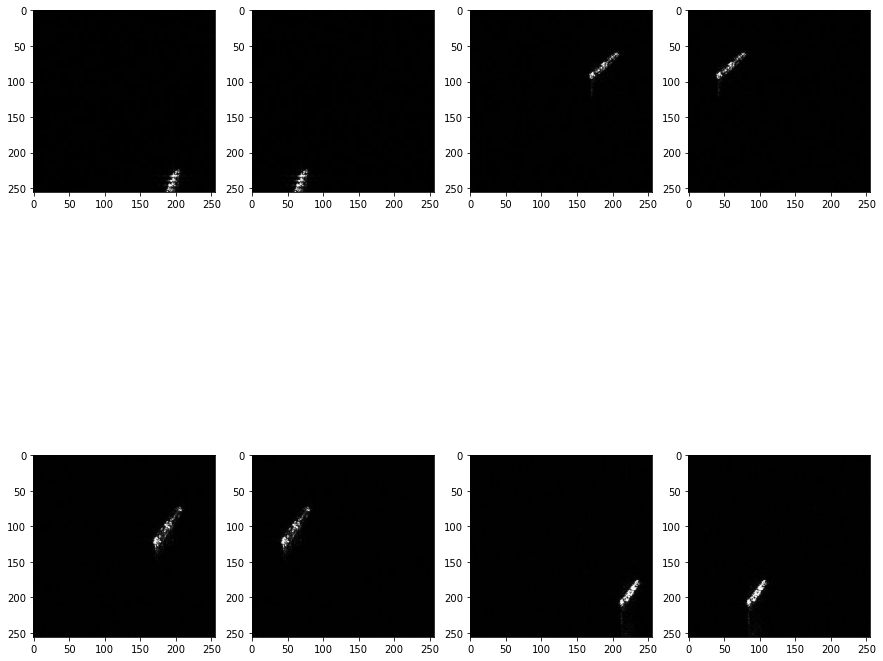

In [172]:
# define functions for vizualization 
    
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,4, figsize=(15, 15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(images[0], cmap='gray')
axarr[0,1].imshow(images[1], cmap='gray')  
axarr[0,2].imshow(images[2], cmap='gray')
axarr[0,3].imshow(images[3], cmap='gray') 
axarr[1,0].imshow(images[4], cmap='gray')
axarr[1,1].imshow(images[5], cmap='gray') 
axarr[1,2].imshow(images[6], cmap='gray')
axarr[1,3].imshow(images[7], cmap='gray')

### Policies for Construction of the Ship Detection Dataset
The procedure for the dataset construction considers the following steps. First, all SAR images are converted to `sigma0` values. Second, candidate subimages containing ships with sizes greater than 800 pixels in both range and azimuth are cropped. Third, sliding windows from these candidate subimages are used to acquire ship chips `256 × 256 pixels` in size. To enrich the backgrounds of the ships, `128 pixels are shifted over both columns and lines` during the sliding window, leading to 50% overlap of adjacent ship chips. To mark the ship position, these ship chips are converted to gray images. Each ship chip corresponds to an Extensible Markup Language (XML) file indicating the **ship location, the ship chip name, and the image shape**.

![ship chip label description](images/ship_label_description.png)

#### Loading annotation from txt files

In [150]:
 # load the image annotations

search_data = "*.txt"
querie = join(target_path_txt, search_data)
annot_paths = glob.glob(querie)

annot = []

i = 0
print('Loading annotations')   
for annotation in annot_paths:
    label = open(annotation, 'r',encoding="UTF8").readline().split("\n")[0].split(" ")
    annot.append(label)

    i +=1
    sys.stdout.write(f"\r {i} / {len(annot_paths)} , {label}")
    sys.stdout.flush() 

Loading annotations
 11795 / 11795 , ['Ship', '2', '73', '35', '21']']]]

In [151]:
# make a dataframe for bbox info
df_annot = pd.DataFrame(annot, columns=['name', 'xmax', 'ymin', 'width', 'height'])
df_annot.groupby('name').size()

name
Ship    11795
dtype: int64

### plot the bbox

<Figure size 432x288 with 0 Axes>

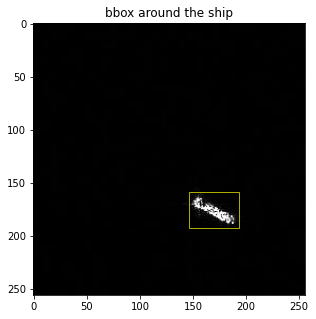

In [166]:
from matplotlib import patches

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, ax = plt.subplots(1, figsize=(5,5)) 
ax.imshow(data[20],cmap="gray")
ax.set_title('bbox around the ship')

# Create a Rectangle patch
#Rectangle((left,upper),width,height))
rect = patches.Rectangle(
        (int(annot[20][1]), int(annot[20][2])), # upper_left,
        int(annot[20][3]), int(annot[20][4]),   # width, height,
        linewidth=0.9,
        edgecolor='y',
        facecolor='none'
)
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()